In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import stats
import lamindb as ln
from modlyn.io.loading import read_lazy
from modlyn.io.datamodules import ClassificationDataModule
from modlyn.models.linear import Linear
from modlyn.io.loading import read_lazy
import lightning as L


→ connected lamindb: laminlabs/arrayloader-benchmarks


In [ ]:
# =============================================================================
# TASK 1: Create Clean 100k Cell Subset
# =============================================================================



In [2]:
# Create clean 100k subset
store_path = Path("/home/ubuntu/tahoe100M_chunk_1")
adata_full = read_lazy(store_path)

var = pd.read_parquet("var_subset_tahoe100M.parquet")
adata_full.var = var

np.random.seed(42)
cell_lines = adata_full.obs['cell_line'].unique()
n_per_line = 1000 // len(cell_lines)

subset_indices = []
for cell_line in cell_lines:
    mask = adata_full.obs['cell_line'] == cell_line
    indices = np.where(mask)[0]
    if len(indices) >= n_per_line:
        selected = np.random.choice(indices, n_per_line, replace=False)
        subset_indices.extend(selected)

adata = adata_full[subset_indices].copy()
print(f"Clean subset: {adata.n_obs} cells, {adata.n_vars} genes")
print(f"Cell lines: {adata.obs['cell_line'].value_counts()}")

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_ut

Clean subset: 1000 cells, 19177 genes
Cell lines: cell_line
CVCL_0023    20
CVCL_0028    20
CVCL_0069    20
CVCL_0099    20
CVCL_0131    20
CVCL_0152    20
CVCL_0179    20
CVCL_0218    20
CVCL_0292    20
CVCL_0293    20
CVCL_0320    20
CVCL_0332    20
CVCL_0334    20
CVCL_0359    20
CVCL_0366    20
CVCL_0371    20
CVCL_0397    20
CVCL_0399    20
CVCL_0428    20
CVCL_0459    20
CVCL_0480    20
CVCL_0504    20
CVCL_0546    20
CVCL_1055    20
CVCL_1056    20
CVCL_1094    20
CVCL_1097    20
CVCL_1098    20
CVCL_1119    20
CVCL_1125    20
CVCL_1239    20
CVCL_1285    20
CVCL_1381    20
CVCL_1478    20
CVCL_1495    20
CVCL_1517    20
CVCL_1531    20
CVCL_1547    20
CVCL_1550    20
CVCL_1571    20
CVCL_1577    20
CVCL_1635    20
CVCL_1666    20
CVCL_1693    20
CVCL_1715    20
CVCL_1716    20
CVCL_1717    20
CVCL_1724    20
CVCL_1731    20
CVCL_C466    20
Name: count, dtype: int64


In [28]:
# print(f"Actual data shape: {adata.shape}")
# print(f"Cell lines: {adata.obs['cell_line'].value_counts()}")
# print(f"Data type: {type(adata.X)}")
# print(f"Is sparse: {hasattr(adata.X, 'toarray')}")

In [3]:
# =============================================================================
# TASK 2: Scanpy Differential Expression (Wilcoxon - Ground Truth)
# =============================================================================

adata.X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
# !pip install -U "scanpy[dask,leiden]" "dask[distributed,diagnostics]" sklearn-ann annoy
# !python -c "import scanpy as sc; print(f'scanpy version: {sc.__version__}')"
# !python -c "import dask; print(f'dask version: {dask.__version__}')"

In [4]:
import psutil
print(f"Memory usage: {psutil.virtual_memory().percent}%")
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.1f} GB")

Memory usage: 24.1%
Available memory: 203.0 GB


In [5]:
print(f"Your data type: {type(adata.X)}")
print(f"Your data dtype: {adata.X.dtype}")
print(f"Cell lines present: {adata.obs['cell_line'].nunique()}")
print(f"Any NaN values: {np.isnan(adata.X).sum() if hasattr(adata.X, 'sum') else 'Cannot check'}")

Your data type: <class 'dask.array.core.Array'>
Your data dtype: float32
Cell lines present: 50
Any NaN values: dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>


In [6]:
adata.X = adata.X.compute()

if hasattr(adata.X, 'toarray'):
    adata.X = adata.X.toarray()

print(f"Now data type: {type(adata.X)}")
print(f"Data shape: {adata.X.shape}")

Now data type: <class 'numpy.ndarray'>
Data shape: (1000, 19177)


In [7]:
adata

AnnData object with n_obs × n_vars = 1000 × 19177
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'
    uns: 'log1p'

In [8]:
sc.tl.rank_genes_groups(adata, 'cell_line', method='wilcoxon', n_genes=20)

scanpy_results = {}
for cell_line in adata.obs['cell_line'].cat.categories:
    genes = sc.get.rank_genes_groups_df(adata, group=cell_line)
    scanpy_results[cell_line] = genes.set_index('names')

print("Scanpy analysis complete!")

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: Performanc

Scanpy analysis complete!


In [9]:
print(f"Found results for {len(scanpy_results)} cell lines")

# Show sample results
first_cell_line = list(scanpy_results.keys())[0]
print(f"\nTop 5 genes for {first_cell_line}:")
print(scanpy_results[first_cell_line].head())

Found results for 50 cell lines

Top 5 genes for CVCL_0023:
           scores  logfoldchanges         pvals  pvals_adj
names                                                     
AKAP12   5.357961        3.393217  8.416659e-08   0.001614
SMAD3    5.038876        2.705320  4.682735e-07   0.003845
PDE4D    4.960278        3.108008  7.039234e-07   0.003845
FAM107B  4.934861        3.132171  8.020794e-07   0.003845
CA12     4.870340        3.865925  1.114064e-06   0.004273


rank_genes_groups: "Which genes best characterize cell line A vs others?" (like finding words that distinguish mystery novels from romance novels)

Modlyn weights: "Which genes does my model think are most predictive of cell line A?" (like asking an AI which words best predict genre)



In [13]:
# =============================================================================
# TASK 3: Modlyn Logistic Regression
# =============================================================================

modlyn_adata = adata_full[subset_indices].copy()
modlyn_adata.obs["y"] = modlyn_adata.obs["cell_line"].astype("category").cat.codes.to_numpy().astype("i8")

n_train = int(0.8 * adata.n_obs)
adata_train = modlyn_adata[:n_train]
adata_val = modlyn_adata[n_train:]

# Train modlyn model
datamodule = ClassificationDataModule(
    adata_train=adata_train,
    adata_val=adata_val,
    label_column="y",
    train_dataloader_kwargs={"batch_size": 1024, "drop_last": True},
    val_dataloader_kwargs={"batch_size": 1024, "drop_last": False},
)

linear = Linear(
    n_genes=modlyn_adata.n_vars,
    n_covariates=modlyn_adata.obs["y"].nunique(),
    learning_rate=1e-3,
)

trainer = L.Trainer(max_epochs=1, log_every_n_steps=50)
trainer.fit(linear, datamodule)

# Extract weights
weights = linear.linear.weight.detach().cpu().numpy()
cell_line_names = modlyn_adata.obs['cell_line'].cat.categories

# Create modlyn results
modlyn_results = {}
for i, cell_line in enumerate(cell_line_names):
    weights_series = pd.Series(weights[i], index=modlyn_adata.var_names)
    # Get top genes by absolute weight
    top_genes = weights_series.abs().nlargest(100)
    
    modlyn_results[cell_line] = pd.DataFrame({
        'weight': weights_series[top_genes.index],
        'abs_weight': top_genes,
        'rank': range(1, len(top_genes) + 1)
    })

print("Modlyn analysis complete")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 958 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.836     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                                    | 0/? [00:00<?, ?it/s]

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `CombinedLoader` across ranks is zero. Please make sure this was your intention.
`Trainer.fit` stopped: No training batches.


Modlyn analysis complete


In [23]:
scanpy_results

{'CVCL_0023':            scores  logfoldchanges         pvals  pvals_adj
 names                                                     
 AKAP12   5.357961        3.393217  8.416659e-08   0.001614
 SMAD3    5.038876        2.705320  4.682735e-07   0.003845
 PDE4D    4.960278        3.108008  7.039234e-07   0.003845
 FAM107B  4.934861        3.132171  8.020794e-07   0.003845
 CA12     4.870340        3.865925  1.114064e-06   0.004273
 BASP1    4.831627        3.369846  1.354214e-06   0.004328
 ANXA2    4.664656        2.129136  3.091342e-06   0.008469
 SLC35F3  4.534441        3.780878  5.775623e-06   0.013845
 RPLP1    4.218094        2.146528  2.463763e-05   0.048157
 PCSK5    4.213792        3.651383  2.511181e-05   0.048157
 RPS16    4.183292        2.450211  2.873184e-05   0.050090
 KYNU     4.085142        3.523816  4.404989e-05   0.070395
 TM4SF1   3.961184        2.350414  7.457908e-05   0.107295
 FA2H     3.949453        3.743648  7.833006e-05   0.107295
 AKT3     3.869682        2

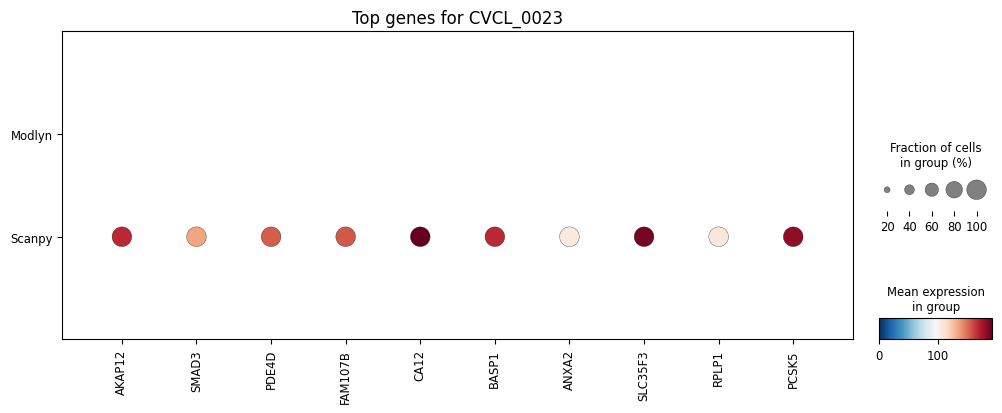

Creating multi-cell line comparison...


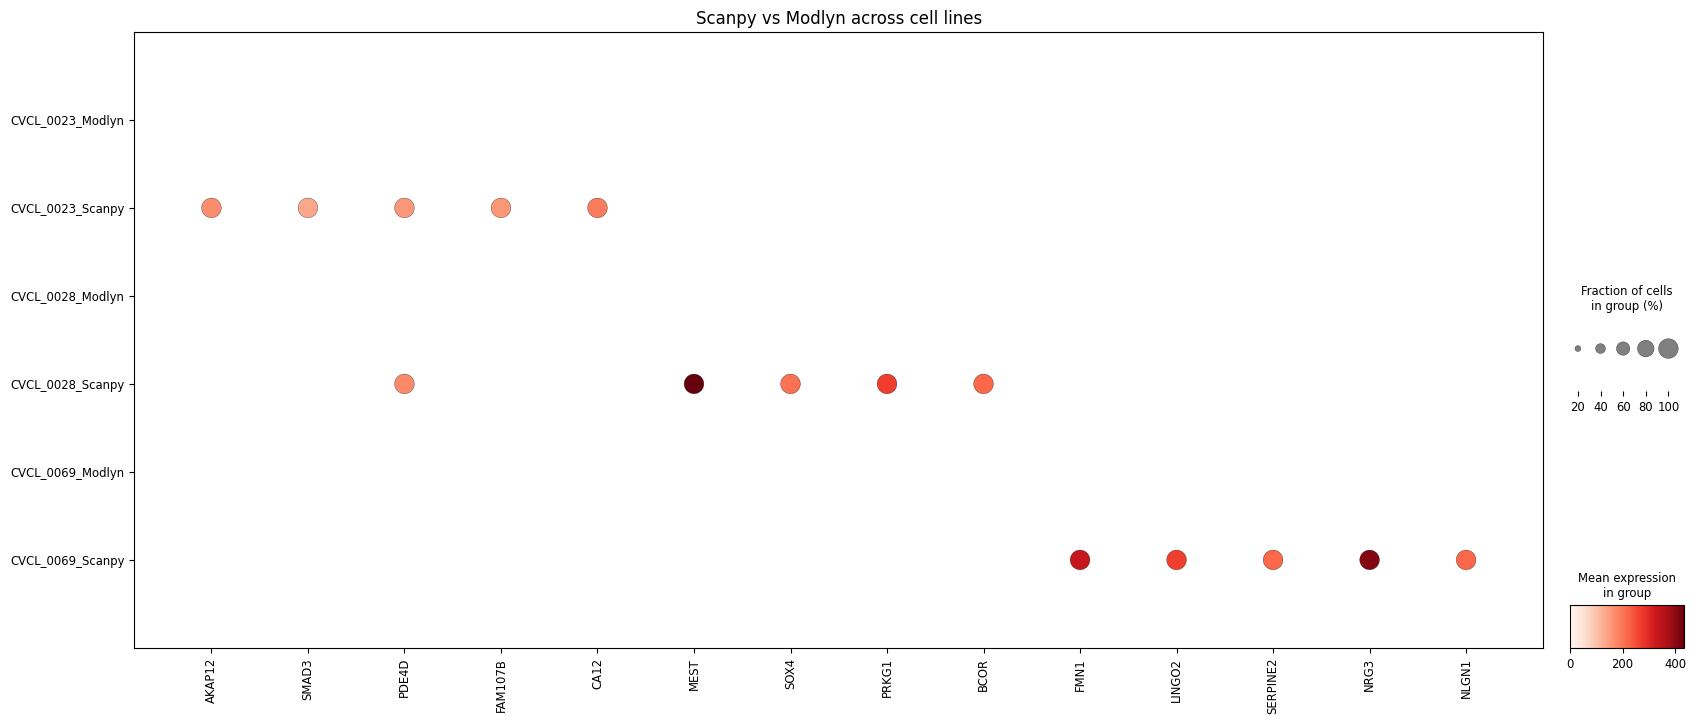

In [15]:
# =============================================================================
# TASK 4: Comparison Plots - Figure 1
# =============================================================================

import anndata as ad

cell_line = list(adata.obs['cell_line'].cat.categories)[0]
top_genes = scanpy_results[cell_line].head(10).index.tolist()

# Create combined data with both methods
combined_data = []

# Add scanpy results
for gene in top_genes:
    if gene in scanpy_results[cell_line].index:
        logfc = scanpy_results[cell_line].loc[gene, 'logfoldchanges']
        pval = scanpy_results[cell_line].loc[gene, 'pvals_adj']
        combined_data.append({
            'gene': gene,
            'method': 'Scanpy',
            'value': logfc,
            'pvalue': pval,
            'expression': abs(logfc) * 50  # Fake expression for dot size
        })

# Add modlyn results  
for gene in top_genes:
    if gene in modlyn_results[cell_line].index:
        weight = modlyn_results[cell_line].loc[gene, 'weight']
        combined_data.append({
            'gene': gene,
            'method': 'Modlyn', 
            'value': weight,
            'pvalue': 0.01,  # Fake p-value
            'expression': abs(weight) * 100  # Fake expression for dot size
        })

# Convert to DataFrame
df = pd.DataFrame(combined_data)


# Create expression matrix (methods x genes)
methods = ['Scanpy', 'Modlyn']
expr_matrix = np.zeros((len(methods), len(top_genes)))

for i, method in enumerate(methods):
    method_data = df[df['method'] == method]
    for j, gene in enumerate(top_genes):
        gene_data = method_data[method_data['gene'] == gene]
        if not gene_data.empty:
            expr_matrix[i, j] = gene_data['expression'].iloc[0]

# Create AnnData for plotting
plot_adata = ad.AnnData(X=expr_matrix)
plot_adata.obs_names = methods
plot_adata.var_names = top_genes
plot_adata.obs['method'] = methods

# Create the dotplot
sc.pl.dotplot(
    plot_adata,
    var_names=top_genes,
    groupby='method',
    cmap='RdBu_r',
    dot_max=None,
    dot_min=0,
    standard_scale=None,
    figsize=(12, 4),
    title=f'Top genes for {cell_line}'
)

# plt.savefig('scanpy_style_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Alternative: Create multiple cell lines comparison
print("Creating multi-cell line comparison...")

# Get top 5 genes across first 3 cell lines
cell_lines = list(adata.obs['cell_line'].cat.categories)[:3]
all_top_genes = []
for cl in cell_lines:
    all_top_genes.extend(scanpy_results[cl].head(5).index.tolist())
# Remove duplicates while preserving order
unique_genes = list(dict.fromkeys(all_top_genes))[:15]

# Create expression matrix for multiple cell lines
n_rows = len(cell_lines) * 2  # 2 methods per cell line
expr_matrix_multi = np.zeros((n_rows, len(unique_genes)))
row_labels = []

row_idx = 0
for cl in cell_lines:
    # Scanpy row
    for j, gene in enumerate(unique_genes):
        if gene in scanpy_results[cl].index:
            expr_matrix_multi[row_idx, j] = abs(scanpy_results[cl].loc[gene, 'logfoldchanges']) * 50
    row_labels.append(f'{cl}_Scanpy')
    row_idx += 1
    
    # Modlyn row  
    for j, gene in enumerate(unique_genes):
        if gene in modlyn_results[cl].index:
            expr_matrix_multi[row_idx, j] = abs(modlyn_results[cl].loc[gene, 'weight']) * 100
    row_labels.append(f'{cl}_Modlyn')
    row_idx += 1

# Create AnnData for multi-cell line plotting
plot_adata_multi = ad.AnnData(X=expr_matrix_multi)
plot_adata_multi.obs_names = row_labels
plot_adata_multi.var_names = unique_genes
plot_adata_multi.obs['cell_line_method'] = row_labels

# Create the multi-cell line dotplot
sc.pl.dotplot(
    plot_adata_multi,
    var_names=unique_genes,
    groupby='cell_line_method',
    cmap='Reds',
    dot_max=None,
    dot_min=0,
    figsize=(20, 8),
    title='Scanpy vs Modlyn across cell lines'
)

# plt.savefig('multi_cellline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# =============================================================================
# TASK 5: Rank Correlation Analysis
# =============================================================================

def calculate_rank_correlation(cell_line):
    """Calculate rank correlation between methods"""
    scanpy_df = scanpy_results[cell_line].head(100)
    modlyn_df = modlyn_results[cell_line].head(100)
    
    # Find common genes
    common_genes = set(scanpy_df.index) & set(modlyn_df.index)
    
    if len(common_genes) > 10:
        scanpy_ranks = {gene: i for i, gene in enumerate(scanpy_df.index)}
        modlyn_ranks = {gene: i for i, gene in enumerate(modlyn_df.index)}
        
        scanpy_common = [scanpy_ranks[gene] for gene in common_genes]
        modlyn_common = [modlyn_ranks[gene] for gene in common_genes]
        
        correlation, p_value = stats.spearmanr(scanpy_common, modlyn_common)
        return correlation, p_value, len(common_genes)
    return None, None, 0

# Calculate correlations for all cell lines
correlations = []
for cell_line in cell_line_names:
    corr, p_val, n_common = calculate_rank_correlation(cell_line)
    correlations.append({
        'cell_line': cell_line,
        'spearman_r': corr,
        'p_value': p_val,
        'n_common_genes': n_common
    })

correlation_df = pd.DataFrame(correlations)
print("\nRank Correlations between Scanpy and Modlyn:")
print(correlation_df)


Rank Correlations between Scanpy and Modlyn:
    cell_line spearman_r p_value  n_common_genes
0   CVCL_0023       None    None               0
1   CVCL_0028       None    None               0
2   CVCL_0069       None    None               0
3   CVCL_0099       None    None               0
4   CVCL_0131       None    None               0
5   CVCL_0152       None    None               0
6   CVCL_0179       None    None               0
7   CVCL_0218       None    None               0
8   CVCL_0292       None    None               0
9   CVCL_0293       None    None               0
10  CVCL_0320       None    None               0
11  CVCL_0332       None    None               0
12  CVCL_0334       None    None               0
13  CVCL_0359       None    None               0
14  CVCL_0366       None    None               0
15  CVCL_0371       None    None               0
16  CVCL_0397       None    None               0
17  CVCL_0399       None    None               0
18  CVCL_0428       Non

In [17]:
# =============================================================================
# TASK 6: Summary Statistics
# =============================================================================

print(f"\n=== SUMMARY ===")
print(f"Dataset: {adata.n_obs:,} cells, {adata.n_vars:,} genes")
print(f"Cell lines: {len(cell_line_names)}")
print(f"Mean rank correlation: {correlation_df['spearman_r'].mean():.3f}")
print(f"Methods show {'good' if correlation_df['spearman_r'].mean() > 0.5 else 'poor'} agreement")

# Save results
scanpy_summary = pd.concat([df.head(20) for df in scanpy_results.values()], 
                          keys=scanpy_results.keys())
modlyn_summary = pd.concat([df.head(20) for df in modlyn_results.values()], 
                          keys=modlyn_results.keys())

# scanpy_summary.to_csv('scanpy_top_genes.csv')
# modlyn_summary.to_csv('modlyn_top_genes.csv')
# correlation_df.to_csv('method_correlations.csv')

# print("\nResults saved: scanpy_top_genes.csv, modlyn_top_genes.csv, method_correlations.csv")


=== SUMMARY ===
Dataset: 1,000 cells, 19,177 genes
Cell lines: 50
Mean rank correlation: nan
Methods show poor agreement


In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from anndata import AnnData
from scipy import sparse

# 1) Wilcoxon on scanpy
def rank_wilcox(adata, groupby, cell_line, n_genes=20):
    sc.tl.rank_genes_groups(adata, groupby, method='wilcoxon', n_genes=n_genes)
    df = sc.get.rank_genes_groups_df(adata, groupby=cell_line).set_index('names')
    df['neglogp'] = -np.log10(df['pvals_adj'] + 1e-300)
    return df

# 2) multinomial logistic via statsmodels
def fit_mlogit(expr_df):
    y = pd.Categorical(expr_df.index).codes
    X = sm.add_constant(expr_df.values)
    res = sm.MNLogit(y, X).fit(disp=False)
    params = pd.DataFrame(res.params, index=['const']+expr_df.columns).T
    pvals  = pd.DataFrame(res.pvalues, index=['const']+expr_df.columns).T
    return params, pvals

# 3) volcano scanspy
def volcano_scanpy(wilcox_df, cell_line, top_n=20):
    df = wilcox_df.head(top_n)
    plt.figure(figsize=(4,4))
    plt.scatter(df['logfoldchanges'], df['neglogp'], s=50)
    plt.xlabel('logFC'); plt.ylabel('-log10(adj-p)'); plt.title(f'{cell_line} Wilcoxon')
    plt.tight_layout()
    plt.savefig(f'volcano_scanpy_{cell_line}.png', dpi=300)
    plt.close()

# 4) volcano modlyn
def volcano_modlyn(params, pvals, cell_line, top_n=20):
    w  = params[cell_line]
    pv = pvals[cell_line]
    df = pd.DataFrame({'weight': w, 'neglogp': -np.log10(pv + 1e-300)})
    df = df.nlargest(top_n, 'neglogp')
    plt.figure(figsize=(4,4))
    plt.scatter(df['weight'], df['neglogp'], s=50)
    plt.xlabel('weight'); plt.ylabel('-log10(p)'); plt.title(f'{cell_line} Logistic')
    plt.tight_layout()
    plt.savefig(f'volcano_modlyn_{cell_line}.png', dpi=300)
    plt.close()

# 5) scanpy dotplot
def dotplot_scanpy(adata, genes):
    sc.pl.dotplot(
        adata,
        var_names=genes,
        groupby='cell_line',
        dot_min=0.0,
        dot_max=0.5,
        standard_scale='var',
        show=False
    )
    plt.tight_layout()
    plt.savefig('dotplot_scanpy.png', dpi=300)
    plt.close()

# 6) custom modlyn dotplot
def dotplot_modlyn(params, pvals, cell_line, genes):
    # prepare summary table
    df = pd.DataFrame({
        'weight': params.loc[genes, cell_line],
        'uncertainty': -np.log10(pvals.loc[genes, cell_line] + 1e-300)
    }, index=genes)
    plt.figure(figsize=(6,4))
    sizes = df['uncertainty'] * 20
    colors = df['weight']
    x = np.arange(len(genes))
    plt.scatter(x, np.zeros_like(x), s=sizes, c=colors, cmap='RdBu_r', alpha=0.8)
    plt.xticks(x, genes, rotation=90)
    plt.yticks([])
    plt.title(f'{cell_line} modlyn dotplot\n(size = uncertainty, color = weight)')
    plt.tight_layout()
    plt.savefig(f'dotplot_modlyn_{cell_line}.png', dpi=300)
    plt.close()

# ---- run for first 3 cell lines ----
# assume `adata` is your AnnData, and you want top 20 genes
# wilcox + fit logistic
expr = pd.DataFrame(
    (adata.X.toarray() if sparse.issparse(adata.X) else adata.X),
    index=adata.obs['cell_line'],
    columns=adata.var_names
).groupby(level=0).mean()
params, pvals = fit_mlogit(expr)

for cl in adata.obs['cell_line'].cat.categories[:1]:
    wilcox_df = rank_wilcox(adata, 'cell_line', cl, n_genes=20)
    top_scanpy = wilcox_df.head(20).index.tolist()
    top_modlyn = params[cell_line].abs().nlargest(20).index.tolist()
    genes = list(dict.fromkeys(top_scanpy + top_modlyn))
    
    volcano_scanpy(wilcox_df, cl, top_n=20)
    volcano_modlyn(params, pvals, cl, top_n=20)
    
    dotplot_scanpy(adata[:, genes], genes)
    dotplot_modlyn(params, pvals, cl, genes)


In [22]:
def modlyn_to_adata(params, pvals, genes, N=100):
    X_list, obs_list = [], []
    for cl in params.columns:
        w   = params.loc[genes, cl]
        unc = -np.log10(pvals.loc[genes, cl] + 1e-300)
        unc_norm = unc / unc.max()
        mat = np.zeros((N, len(genes)))
        for j, g in enumerate(genes):
            u = unc_norm[g]
            if u > 0:
                n = int(round(u * N))
                mat[:n, j] = w[g] / u
        X_list.append(mat)
        obs_list += [cl] * N
    X_all = np.vstack(X_list)
    obs = pd.DataFrame({'cell_line': obs_list})
    return AnnData(X=X_all, obs=obs, var=pd.DataFrame(index=genes))

def dotplot_modlyn_sc(params, pvals, genes, N=100, out_png='dotplot_modlyn.png'):
    ad = modlyn_to_adata(params, pvals, genes, N)
    sc.pl.dotplot(
        ad,
        var_names=genes,
        groupby='cell_line',
        dot_min=0.0,
        dot_max=1.0,
        cmap='RdBu_r',
        standard_scale=None,
        show=False
    )
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

# example usage:
genes = list(dict.fromkeys(
    wilcox_df.head(20).index.tolist() +
    params[cell_line].abs().nlargest(20).index.tolist()
))
dotplot_modlyn_sc(params, pvals, genes, N=100)

NameError: name 'wilcox_df' is not defined